In [107]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, entropy
import numpy as np
import pandas as pd
import seaborn as sns
import akshare as ak
import baostock as bs
from utils import get_index_components, get_csindex_components, get_history_k
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows',100)

## 思路
1. PE
2. Pearson相关性 with 上证
3. 线性回归斜率 with 上证

In [2]:
get_csindex_components()

array(['sh.688008', 'sh.688009', 'sh.688012', 'sh.688036', 'sh.688041',
       'sh.688047', 'sh.688072', 'sh.688082', 'sh.688111', 'sh.688126',
       'sh.688169', 'sh.688187', 'sh.688188', 'sh.688223', 'sh.688256',
       'sh.688271', 'sh.688303', 'sh.688349', 'sh.688396', 'sh.688472',
       'sh.688506', 'sh.688599', 'sh.688728', 'sh.688777', 'sh.688981',
       'sz.300014', 'sz.300122', 'sz.300124', 'sz.300142', 'sz.300223',
       'sz.300274', 'sz.300308', 'sz.300316', 'sz.300347', 'sz.300394',
       'sz.300408', 'sz.300433', 'sz.300442', 'sz.300450', 'sz.300502',
       'sz.300628', 'sz.300661', 'sz.300750', 'sz.300751', 'sz.300759',
       'sz.300760', 'sz.300782', 'sz.300832', 'sz.300919', 'sz.301269'],
      dtype=object)

In [2]:
def get_corr(stock_list, stt_date, end_date, market='sh.000001', min_samples=122):
    """
    计算股票收益率分布与市场收益率分布之间的Pearson相关系数
    """
    corr_list = []
    df_stock = get_history_k(stock_list, stt_date, end_date)
    df_stock['pct_chg'] = df_stock['pct_chg'].fillna(method="ffill").fillna(method='bfill')
    df_market = get_history_k([market],stt_date, end_date).rename(columns={"pct_chg":"pct_chg_m"})
    df_market['pct_chg_m'] = df_market['pct_chg_m'].fillna(method="ffill").fillna(method='bfill')
    for s in stock_list:
        df_merge = pd.merge(df_stock[df_stock['code']==s], df_market[['date','pct_chg_m']], on='date', how='left')
        if df_merge.shape[0]<min_samples:
            corr_ = 0
        else:
            v_s = df_merge['pct_chg'].values
            v_m = df_merge['pct_chg_m'].values
            corr_ = pearsonr(v_s, v_m).statistic
        corr_list.append(corr_)
    return corr_list

# get_corr(['sh.688008', 'sh.688009', 'sh.688012'],'2023-01-01','2024-08-31')
get_corr(['sz.300103'], '2024-01-01','2024-11-20')

login success!
logout success!
login success!
logout success!


[0.3435829163919291]

In [83]:
def get_slope(stock_list, stt_date, end_date, market='sh.000001', anomaly_q=0.98, min_samples=122):
    """
    计算股票收益率分布与市场收益率分布之间的线性回归beta & alpha
    """
    slope_list = []
    intercept_list = []
    slope_pos_list = []
    intercept_pos_list = []
    slope_neg_list = []
    intercept_neg_list = []
    # 获取市场指数数据
    df_market = get_history_k([market], stt_date, end_date)
    df_market['pct_chg'] = df_market['pct_chg'].fillna(method="ffill").fillna(method='bfill')
    df_stock = get_history_k(stock_list, stt_date, end_date)
    df_stock['pct_chg'] = df_stock['pct_chg'].fillna(method="ffill").fillna(method='bfill')
    
    for s in stock_list:
        # 合并股票和市场数据
        df_merge = pd.merge(
            df_stock[df_stock['code']==s], 
            df_market[['date','pct_chg']].rename(columns={'pct_chg':'pct_chg_m'}), 
            on='date', 
            how='left'
        )
        if df_merge.shape[0]<min_samples:
            slope, intercept = 0, 0
            slope_pos, intercept_pos = 0, 0
            slope_neg, intercept_neg = 0, 0
        else:
            thresh = df_merge['pct_chg_m'].abs().quantile(anomaly_q)
            df_merge_ = df_merge[df_merge['pct_chg_m'].abs()<=thresh]
            # 计算线性回归斜率
            x = df_merge_['pct_chg_m'].values
            y = df_merge_['pct_chg'].values
            slope, intercept = np.polyfit(x, y, 1)  # polyfit返回[slope, intercept]
            # 市场上涨时候的slope
            x_pos = df_merge_[df_merge_['pct_chg_m']>0]['pct_chg_m'].values
            y_pos = df_merge_[df_merge_['pct_chg_m']>0]['pct_chg'].values
            slope_pos, intercept_pos = np.polyfit(x_pos, y_pos, 1)
            # 市场下跌时候的slope
            x_neg = df_merge_[df_merge_['pct_chg_m']<0]['pct_chg_m'].values
            y_neg = df_merge_[df_merge_['pct_chg_m']<0]['pct_chg'].values
            slope_neg, intercept_neg = np.polyfit(x_neg, y_neg, 1)
        slope_list.append(slope)
        intercept_list.append(intercept)
        slope_pos_list.append(slope_pos)
        intercept_pos_list.append(intercept_pos)
        slope_neg_list.append(slope_neg)
        intercept_neg_list.append(intercept_neg)
        
    return slope_list, intercept_list, slope_pos_list, intercept_pos_list, slope_neg_list, intercept_neg_list

get_slope(['sh.688008', 'sh.688009', 'sh.688012'],'2024-01-01','2024-10-31')

login success!
logout success!
login success!
logout success!


([1.4578637993197956, 1.1738834192530105, 1.4217227808951518],
 [-0.06843213444184443, 0.10355462496393696, -0.059198074232744924],
 [1.6188542271331068, 1.6239701882523492, 2.118468365101716],
 [-0.38839977083903776, -0.39366740215493073, -0.8663993183479828],
 [2.1655421921233917, 1.1430436751616386, 1.5635700365671832],
 [0.6605540460359404, 0.2577313551852126, 0.35722300322924716])

login success!
logout success!
login success!
logout success!


(1.755437529563986,
 0.2942018681202993,
 2.048400446300466,
 0.14036845041060536,
 1.1055539141672701,
 -0.24171014148551553)

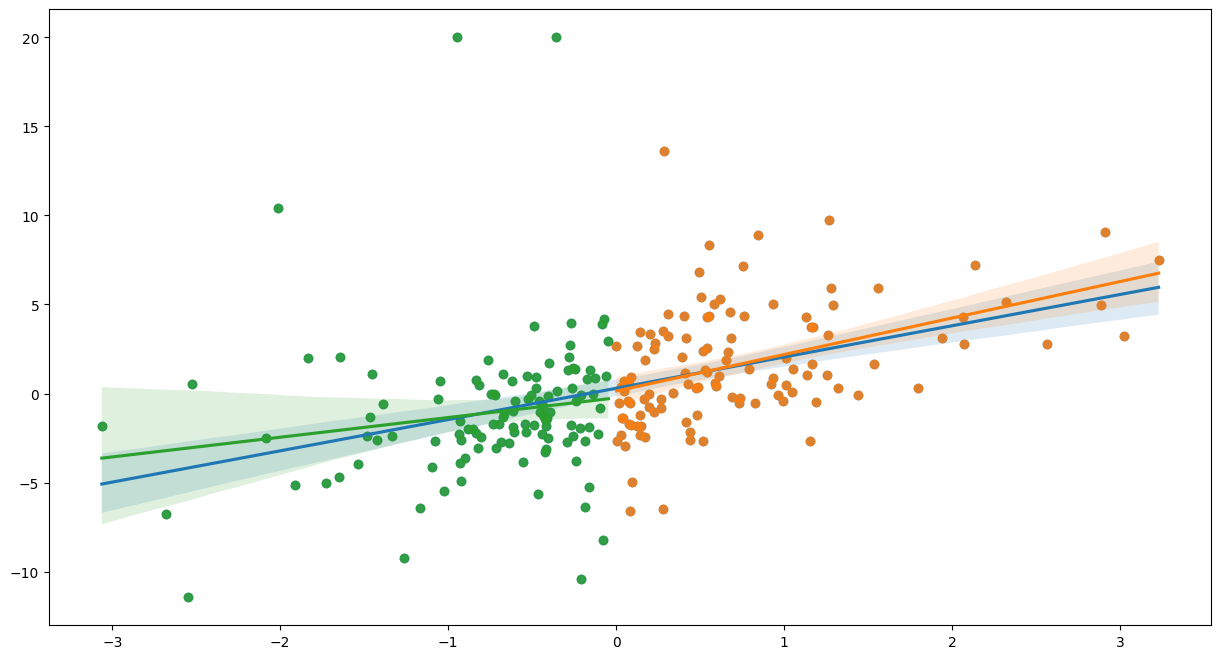

In [110]:
def draw_slope(stock_code, stt_date, end_date, market='sh.000001', anomaly_q=0.98, min_samples=122):
    # 获取市场指数数据
    df_market = get_history_k([market], stt_date, end_date)
    df_market['pct_chg'] = df_market['pct_chg'].fillna(method="ffill").fillna(method='bfill')
    df_stock = get_history_k([stock_code], stt_date, end_date)
    df_stock['pct_chg'] = df_stock['pct_chg'].fillna(method="ffill").fillna(method='bfill')
    
    # 合并股票和市场数据
    df_merge = pd.merge(
        df_stock, 
        df_market[['date','pct_chg']].rename(columns={'pct_chg':'pct_chg_m'}), 
        on='date', 
        how='left'
    )
    if df_merge.shape[0]<min_samples:
        slope, intercept = 0, 0
        slope_pos, intercept_pos = 0, 0
        slope_neg, intercept_neg = 0, 0
    else:
        thresh = df_merge['pct_chg_m'].abs().quantile(anomaly_q)
        df_merge_ = df_merge[df_merge['pct_chg_m'].abs()<=thresh]
        # 计算线性回归斜率
        x = df_merge_['pct_chg_m'].values
        y = df_merge_['pct_chg'].values
        slope, intercept = np.polyfit(x, y, 1)  # polyfit返回[slope, intercept]
        # 市场上涨时候的slope
        x_pos = df_merge_[df_merge_['pct_chg_m']>0]['pct_chg_m'].values
        y_pos = df_merge_[df_merge_['pct_chg_m']>0]['pct_chg'].values
        slope_pos, intercept_pos = np.polyfit(x_pos, y_pos, 1)
        # 市场下跌时候的slope
        x_neg = df_merge_[df_merge_['pct_chg_m']<0]['pct_chg_m'].values
        y_neg = df_merge_[df_merge_['pct_chg_m']<0]['pct_chg'].values
        slope_neg, intercept_neg = np.polyfit(x_neg, y_neg, 1)
        # draw
        plt.figure(figsize=(15,8))
        sns.regplot(x=x, y=y)
        sns.regplot(x=x_pos, y=y_pos)
        sns.regplot(x=x_neg, y=y_neg)
        
    return slope, intercept, slope_pos, intercept_pos, slope_neg, intercept_neg

draw_slope('sz.300442','2024-01-01','2024-12-20', anomaly_q=0.98)

In [4]:
def get_kld(stock_list, stt_date, end_date, market='sh.000001', bins=50, min_samples=122):
    """
    计算股票收益率分布与市场收益率分布之间的KL散度
    """
    
    kl_list = []
    # 获取市场指数数据
    df_market = get_history_k([market], stt_date, end_date)
    df_market['pct_chg'] = df_market['pct_chg'].fillna(method="ffill").fillna(method='bfill')
    market_returns = df_market['pct_chg'].values
    
    
    df_stock = get_history_k(stock_list, stt_date, end_date)
    df_stock['pct_chg'] = df_stock['pct_chg'].fillna(method="ffill").fillna(method='bfill')
    for s in stock_list:
        # 获取股票收益率
        stock_returns = df_stock[df_stock['code']==s]['pct_chg'].values
        if len(stock_returns)<min_samples:
            kl_div = 9999
        else:
            range_max = np.max([np.max(stock_returns),np.max(market_returns)])
            range_min = np.min([np.min(stock_returns), np.min(market_returns)])
            
            # 计算市场收益率的概率分布
            market_hist, bin_edges = np.histogram(market_returns, bins=bins, 
                range=(range_min, range_max), density=True)
            market_hist = market_hist + 1e-10  # 避免出现0
            # 使用相同的bin边界计算股票收益率的概率分布
            stock_hist, _ = np.histogram(stock_returns, bins=bin_edges, 
                range=(range_min, range_max) , density=True)
            stock_hist = stock_hist + 1e-10  # 避免出现0

            # 计算KL散度
            kl_div = entropy(stock_hist, market_hist)
        kl_list.append(kl_div)
    
    return kl_list

get_kld(['sh.688008', 'sh.688009', 'sh.688012'],'2024-01-01','2024-10-31')

login success!
logout success!
login success!
logout success!


[4.464426743137549, 2.8101924814932464, 2.8668645462127915]

In [36]:
watch_date = '2024-12-19'
stt_date = '2024-01-01'
end_date = watch_date

# 创业板
# stock_list = get_index_components()
stock_list = get_csindex_components()
# stock_list = get_csindex_components('000300')
# stock_list = ['sz.000001','sz.000002']
df_res = get_history_k(stock_list, watch_date, watch_date)
df_res['corr'] = get_corr(stock_list, stt_date, end_date)
df_res[['beta','alpha']] = np.transpose(get_slope(stock_list, stt_date, end_date))
# df_res['kld'] = get_kld(stock_list, stt_date, end_date)

df_res

login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!


,date,code,open,high,low,close,preclose,volume,amount,adjustflag,...,tradestatus,pct_chg,pe_ttm,ps_ttm,pcf_ncf_ttm,pb_mrq,is_st,corr,beta,alpha
0,2024-12-19,sh.688008,67.50,71.48,67.07,70.79,68.80,41139408,2.871297e+09,2,...,1,2.8924,67.669214,24.277847,171.012058,7.699569,0,0.622740,1.280844,-0.065104
0,2024-12-19,sh.688009,6.41,6.46,6.38,6.44,6.46,27324037,1.752337e+08,2,...,1,-0.3096,20.856809,2.045361,-42.228726,1.529329,0,0.676681,1.054145,0.023465
0,2024-12-19,sh.688012,190.07,196.17,188.80,194.88,194.30,11788569,2.268795e+09,2,...,1,0.2985,78.805821,15.691463,82.207690,6.471247,0,0.576297,0.997471,-0.153007
0,2024-12-19,sh.688036,90.22,95.94,89.50,95.49,90.76,10883274,1.025201e+09,2,...,1,5.2115,19.597941,1.544034,-35.568006,5.367329,0,0.537308,0.939695,-0.020893
0,2024-12-19,sh.688041,120.55,130.89,119.52,128.78,121.20,33519717,4.248732e+09,2,...,1,6.2541,158.604474,36.477578,-109.509092,15.099511,0,0.561765,0.941415,0.016150
0,2024-12-19,sh.688047,139.17,144.44,139.17,142.05,142.01,4026950,5.742687e+08,2,...,1,0.0282,-122.419794,135.893146,-350.447659,17.739352,0,0.590112,1.320890,-0.130819
0,2024-12-19,sh.688072,164.00,166.50,161.50,164.40,166.55,4002286,6.576519e+08,2,...,1,-1.2909,69.029114,13.948785,-52.583982,9.613388,0,0.581127,1.301174,-0.212652
0,2024-12-19,sh.688082,104.20,106.29,104.20,104.95,105.50,1654000,1.739916e+08,2,...,1,-0.5213,46.226894,9.001752,61.601944,6.411669,0,0.640192,1.245888,-0.130025
0,2024-12-19,sh.688111,310.04,318.00,306.35,309.16,313.98,4529538,1.406092e+09,2,...,1,-1.5351,97.651007,29.108743,-51.488888,13.358506,0,0.663034,1.683949,-0.072760
0,2024-12-19,sh.688126,20.49,20.74,20.21,20.53,20.61,18096007,3.722364e+08,2,...,1,-0.3882,-100.272476,17.201815,-89.902228,4.357046,0,0.530608,1.302457,-0.185200


In [17]:
get_slope(['sz.300413'],'2024-07-01', '2024-11-27',anomaly_q=0.9,min_samples=42)

login success!
logout success!
login success!
logout success!


([1.2213381976916489], [0.13984466506896429])

login success!
logout success!


<Axes: xlabel='date', ylabel='close'>

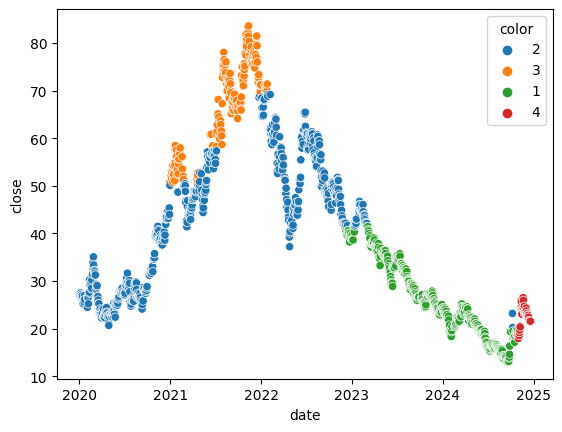

In [82]:
df_spec = get_history_k(['sz.300450'],stt_date='2015-01-01',end_date='2024-12-19')
df_spec['pe_ttm'].fillna(method='ffill',inplace=True)
df_spec['color'] = pd.cut(df_spec['pe_ttm'],bins=[-np.inf,0,30,100,300,np.inf]).cat.codes.astype(str)
sns.scatterplot(df_spec.query("date>='2020-01-01'"), x='date',y='close',hue='color')


In [76]:
df_res[['code','pe_ttm','corr','beta','alpha']].query("beta>1.2 and corr>0.5").sort_values('pe_ttm')


,code,pe_ttm,corr,beta,alpha
0,sh.688599,-123.292301,0.614173,1.329154,-0.308731
0,sh.688047,-122.419794,0.590112,1.320890,-0.130819
0,sh.688126,-100.272476,0.530608,1.302457,-0.185200
0,sz.300316,10.607412,0.671157,1.368654,-0.294015
0,sz.300122,18.137484,0.694242,1.378278,-0.485099
0,sz.300919,18.496426,0.717982,1.473584,-0.139471
0,sh.688472,22.734688,0.585964,1.216481,-0.139246
0,sz.300014,25.185131,0.710160,1.594002,-0.145118
0,sz.300759,26.253159,0.679105,1.524291,-0.105060
0,sz.300433,30.247711,0.732310,1.434220,0.101378


In [23]:
get_slope(['sz.300475'],'2024-01-01','2024-12-16', anomaly_q=0.95)

login success!
logout success!
login success!
logout success!


([2.0244190731408427], [-0.18397903947788696])

In [8]:
df_res.sort_values('pe_ttm', ascending=True)

,date,code,open,high,low,close,preclose,volume,amount,adjustflag,...,pct_chg,pe_ttm,ps_ttm,pcf_ncf_ttm,pb_mrq,is_st,corr,beta,alpha,kld
0,2024-11-20,sh.688256,456.000000,479.650000,449.010000,475.000000,461.000000,9330080,4.328962e+09,1,...,3.0369,-259.138173,264.783851,-244.801632,38.591205,0,0.481804,1.355326,0.293206,6.694667
0,2024-11-20,sh.688303,31.017118,31.338482,30.385473,31.061445,31.006037,7931781,2.208944e+08,1,...,0.1787,-133.149165,6.358324,-3.510797,1.434533,0,0.527468,1.121999,-0.254985,3.130423
0,2024-11-20,sh.688599,25.716825,25.802050,25.258737,25.429188,25.812704,17933932,4.294054e+08,1,...,-1.4858,-132.626731,0.545186,48.466446,1.831780,0,0.612699,1.323233,-0.305746,4.771022
0,2024-11-20,sh.688047,146.910000,153.000000,144.900000,150.440000,145.000000,5983424,8.959906e+08,1,...,3.7517,-129.650361,143.919499,-371.146397,18.787104,0,0.604875,1.359248,-0.118652,4.796610
0,2024-11-20,sh.688126,23.060881,23.481993,22.870378,23.100987,23.221305,21791512,5.040096e+08,1,...,-0.5181,-112.531800,19.304910,-100.893684,4.889739,0,0.522164,1.275613,-0.148985,3.269046
0,2024-11-20,sz.300316,341.507849,344.839169,335.797016,341.507849,343.697002,17981305,6.427651e+08,1,...,-0.6369,11.735860,2.473046,-165.743142,2.757300,0,0.665524,1.350124,-0.275805,5.089690
0,2024-11-20,sz.300274,804.578860,812.927901,792.199247,797.861241,816.478643,35458120,2.954184e+09,1,...,-2.2802,17.559532,2.274508,26.272380,5.045724,0,0.592795,1.023036,-0.023142,2.877254
0,2024-11-20,sh.688169,618.435044,618.435044,610.775527,612.562748,620.477582,2299445,4.970829e+08,1,...,-1.2756,18.440294,4.000019,265.657703,3.242635,0,0.540240,0.906633,0.075967,3.937928
0,2024-11-20,sh.688036,145.494291,146.605759,140.631617,144.058644,146.960811,12259867,1.132649e+09,1,...,-1.9748,19.152580,1.508946,-34.759727,5.245357,0,0.561225,0.988433,0.037747,3.758485
0,2024-11-20,sh.688187,50.506274,51.026421,50.256603,50.818362,50.703930,4308116,2.096880e+08,1,...,0.2257,19.402864,2.877860,-87.914774,1.700859,0,0.623870,1.190289,0.024604,3.301292


In [33]:
pearsonr

ValueError: x and y must have the same length.

In [11]:
?np.corrcoef

Signature:
np.corrcoef(
    x,
    y=None,
    rowvar=True,
    bias=<no value>,
    ddof=<no value>,
    *,
    dtype=None,
)
Docstring:
Return Pearson product-moment correlation coefficients.

Please refer to the documentation for `cov` for more detail.  The
relationship between the correlation coefficient matrix, `R`, and the
covariance matrix, `C`, is

.. math:: R_{ij} = \frac{ C_{ij} } { \sqrt{ C_{ii} C_{jj} } }

The values of `R` are between -1 and 1, inclusive.

Parameters
----------
x : array_like
    A 1-D or 2-D array containing multiple variables and observations.
    Each row of `x` represents a variable, and each column a single
    observation of all those variables. Also see `rowvar` below.
y : array_like, optional
    An additional set of variables and observations. `y` has the same
    shape as `x`.
rowvar : bool, optional
    If `rowvar` is True (default), then each row represents a
    variable, with observations in the columns. Otherwise, the relationship
    is tra